In [2]:
import sys
sys.path.append("../")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.autograd.profiler as profiler

import apex.fp16_utils as fp16

import os
import time, gc
from progressbar import progressbar
import numpy as np
from sklearn.datasets import make_classification
from collections import defaultdict
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser
import matplotlib.pyplot as plt
%matplotlib inline

from utils.moduleCodeProfiler import rankByCriteria

In [3]:
!nvidia-smi

Wed Nov 25 22:48:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 0000BCA9:00:00.0 Off |                  Off |
| N/A   30C    P0    26W / 250W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
cuda0 = torch.device('cuda:0') 

In [5]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
args = parser.parse_args('')

args.data_dir = '~/datadrive'
args.dataset_dir = 'toy_mlp_1'
args.seed = 123
args.batch_size = 1000
# Large
# args.hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# Medium
# args.hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# Small
args.hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
args.lr = 0.01
args.epochs = 2000

# Toy Data Generation

In [6]:
# construct and save toydataset

m_train = 9000
m_total = m_train

# EASY
# X, y = make_classification(n_samples=m_total, n_features=10, n_informative=10, n_redundant=0, n_repeated=0, n_classes=5, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=args.seed)
# HARD
X, y = make_classification(n_samples=m_total, n_features=1000, n_informative=500, n_redundant=0, n_repeated=0, n_classes=1000, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=args.seed)


np.random.seed(args.seed)
permutation = np.random.permutation(m_total)
print('First 10 training indices', permutation[:10])
print('X shape', X.shape)
print('y shape', y.shape)

train_indices = permutation[0:m_train]

dataset_dir = 'toy_mlp_1'
os.makedirs(os.path.join(args.data_dir, dataset_dir, 'train'), mode = 0o777, exist_ok = True) 

np.save(os.path.join(args.data_dir, dataset_dir, 'train', 'features.npy'), X[train_indices])
np.save(os.path.join(args.data_dir, dataset_dir, 'train', 'labels.npy'), y[train_indices])

First 10 training indices [1603 8472 2213  498 1038 8399 3324 7535 1519 1959]
X shape (9000, 1000)
y shape (9000,)


In [7]:
class ToyDataset(Dataset):
    """Toy dataset construction."""

    def __init__(self, data_dir):
        """
        Args:
            data_dir (string): Path to the directory with data files.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # shape (m, nx)
        self.X = np.load(os.path.join(data_dir, 'features.npy'))
        # shape (m, ny=1)
        self.y = np.load(os.path.join(data_dir, 'labels.npy'))
        

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        else:
            X = torch.from_numpy(self.X[idx, :]).type(torch.HalfTensor)
            y = torch.tensor(self.y[idx], dtype=torch.long)
            sample = {'X': X, 'y': y}

        return sample

# Model

In [8]:
class MLPLazy(nn.Module):

    def __init__(self, nx, hidden_layer_dims, ny):
        super(MLPLazy, self).__init__()
        self.hidden_layer_dims = hidden_layer_dims
        
        linear_layers = []
        last_dim = nx
        for next_dim in hidden_layer_dims:
            linear_layer = nn.Linear(last_dim, next_dim)
            linear_layers.append(linear_layer)
            last_dim = next_dim
        # should push to ModuleList so that params stay on cuda
        self.linear_layers = nn.ModuleList(linear_layers)
        self.scorer = nn.Linear(last_dim, ny)

    def forward(self, X):
        '''
        X has shape (m, nx)
        '''
        last_X = X
        for i, linear_layer in enumerate(self.linear_layers):
            # shape (m, self.hidden_layer_dims[i])
            last_X = linear_layer(last_X)
            # shape (m, self.hidden_layer_dims[i])
            last_X = torch.relu(last_X)
        # shape (m, ny)
        z = self.scorer(last_X)
        # shape (m, ny)
        a = torch.softmax(z, dim=1)
        return z, a

# Timer

In [9]:
def start_timer():
    global start_time
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer():
    torch.cuda.synchronize()
    end_time = time.time()
    return end_time - start_time

# Workflow

In [10]:
def check_weights_precision(model):
    '''check weight precisions for each layer of MLP'''
    for i, layer in enumerate(model.linear_layers):
        print(f'layer {i}, weight dtype {layer.weight.dtype}')
        print(f'layer {i}, bias dtype {layer.bias.dtype}')
    print(f'scorer weight dtype {model.scorer.weight.dtype}')
    print(f'scorer bias dtype {model.scorer.bias.dtype}')

In [11]:
def get_master(opt):
    '''create a float32 master copy of float16 model weights in optimizer'''
    model_pgs = [[param for param in pg['params'] if param.requires_grad] for pg in opt.param_groups]
    master_pgs = [[param.clone().float().detach() for param in pg] for pg in model_pgs]
    for pg in master_pgs:
        for param in pg: param.requires_grad_(True)
    return model_pgs, master_pgs

In [12]:
def push_master_to_optimizer(opt, master_pgs):
    '''
        link master copy pgs to optimizer, 
        keeping other hparams such as lr, momentum dampening, weight_decay...'''
    for opt_pg, master_pg in zip(opt.param_groups, master_pgs):
        opt_pg['params'] = master_pg

In [13]:
def to_master_grads(model_pgs, master_pgs, flat_master:bool=False):
    '''copy float16 gradients from model to float32 gradients in master copy of weights'''
    for (model_params,master_params) in zip(model_pgs,master_pgs):
        fp16.model_grads_to_master_grads(model_params, master_params, flat_master=flat_master)

In [14]:
def to_model_params(model_pgs, master_pgs, flat_master:bool=False)->None:
    '''copy master copy of updated weights in float32 to model weights in float 16'''
    for (model_params,master_params) in zip(model_pgs,master_pgs):
        fp16.master_params_to_model_params(model_params, master_params, flat_master=flat_master)

In [15]:
def scale_down_master_grad(master_pgs, loss_scale):
    '''
    scale down all gradients for all master param groups
    '''
    for master_params in master_pgs:
        for param in master_params:
            if param.grad is not None:
                param.grad.div_(loss_scale)

In [16]:
def get_max_memory_alloc():
    devices_max_memory_alloc = {}
    for i in range(torch.cuda.device_count()):
        device = torch.device(f'cuda:{i}')
        devices_max_memory_alloc[f'cuda:{i}'] = torch.cuda.max_memory_allocated(device) / 1e6
        torch.cuda.reset_max_memory_allocated(device)
    return devices_max_memory_alloc

In [17]:
def check_overflow(loss, param_groups):
    '''check if any loss or gradients in parameter groups overflow'''
    loss_overflow = torch.isinf(loss)
    if loss_overflow: return True
    grad_overflow = torch.any(torch.stack([torch.any(torch.isinf(p.grad)) for pg in param_groups for p in pg]))
    return grad_overflow

In [20]:
def main_train(args, gpu=0, debug=False):

    torch.manual_seed(args.seed)
    
    ################################################################
    # load datasets
    training_set = ToyDataset(data_dir=os.path.join(args.data_dir, args.dataset_dir, 'train'))
    training_generator = torch.utils.data.DataLoader(dataset=training_set, 
                                                        batch_size=args.batch_size, 
                                                        shuffle=True, 
                                                        num_workers=0, 
                                                        pin_memory=True)

    nx = training_set.X.shape[1]
    ny = max(training_set.y) + 1
    ################################################################

    # 1. Create model
    model = MLPLazy(nx, args.hidden_layer_dims, ny)  # single
    loss_criterion = nn.CrossEntropyLoss(reduction='mean')
    torch.cuda.set_device(gpu)
    model.to(device=gpu)    

    # 2. initialize optimizer
    opt = torch.optim.SGD(model.parameters(), lr=args.lr)  # half
    if debug:
        print('\nmodel weights at init')
        check_weights_precision(model)

    # 3. Cast model to float16
    fp16.convert_network(model, torch.float16)
#     model.half()
    if debug:
        print('\nmodel weights after casting')
        check_weights_precision(model)

    # 4. Create a copy of this float16 model's weight in float32 as the master copy
    model_pgs, master_pgs = get_master(opt)  # half, single

    # 5. replace optimizer float16 weights with float32 master copy
    push_master_to_optimizer(opt, master_pgs)  # opt single

    def check_grad():
        print('optimizer grad:\n', opt.param_groups[0]['params'][0].grad)
        print('master pg grad:\n', master_pgs[0][0].grad)
        print('model pg grad:\n', model_pgs[0][0].grad)

    def check_weights():
        print('optimizer weights:\n', opt.param_groups[0]['params'][0])
        print('master pg weights:\n', master_pgs[0][0])
        print('model pg weights:\n', model_pgs[0][0])

    history = {
        'epoch_train_losses': [], 'step_train_losses': [], 'max_memory_allocation':[], 
        'loss_scales':[], 'timing': defaultdict(int)
    }
    loss_scale = 50000
    
    loop_start_time = time.time()
    
    for e in progressbar(range(args.epochs)):
        start_timer()
        model.train()
        sum_batch_losses = torch.tensor([0.], dtype=torch.float, device=gpu)
        all_batch_losses = []
        batch_max_memory_alloc = []
        loss_scales = []
        history['timing']['epoch_setup'] += end_timer()
        
        epoch_start_time = time.time()
        for batch_i, batch_data in enumerate(training_generator):
            batch_start_time = time.time()
            
            if debug: 
                print(f'\nRunning batch_{batch_i}-----------------------------------------')

            loss_scales.append(loss_scale)
            
            start_timer()
            batch_max_memory_alloc.append(get_max_memory_alloc()['cuda:0'])
            history['timing']['get_memory'] += end_timer()

            # 6. model forward with float16 data
            # NOTE: model zero grad, master last grad
            start_timer()
            batch_X = batch_data['X'].cuda(gpu, non_blocking=True) # half
            batch_y = batch_data['y'].cuda(gpu, non_blocking=True) # long
            history['timing']['data'] += end_timer()
            
            start_timer()
            logits, activations = model(batch_X) # Half
            history['timing']['forward'] += end_timer()
            
            # 7. compute loss in float16
            # NOTE: model zero grad, master last grad
            start_timer()
            loss = loss_criterion(logits, batch_y)  # half
            history['timing']['loss'] += end_timer()
            if debug:
                print('\nComputed loss')
                check_grad()
                check_weights()
                
            # log the loss metric
            torch.cuda.synchronize()

            start_timer()
            sum_batch_losses += loss
            all_batch_losses.append(loss)
            history['timing']['append_losses'] += end_timer()
            if debug:
                print('all_batch_losses:', all_batch_losses)

            # 8. scale up loss here
            if debug:            
                print('\nloss scale in scale up:', loss_scale)
                print('loss before scaling:', loss.item(), loss.dtype)
            start_timer()
            if torch.isnan(loss):
                print(f'e{e} b{batch_i} loss is nan before scaling')
            if torch.isinf(loss):
                print(f'e{e} b{batch_i} loss is inf before scaling')                
            loss *= loss_scale
            if torch.isnan(loss):
                print(f'e{e} b{batch_i} loss is nan after scaling')
            if torch.isinf(loss):
                print(f'e{e} b{batch_i} loss is inf after scaling')     
            history['timing']['scale_up_loss'] += end_timer()
            if debug:     
                print('loss after scaling:', loss.item(), loss.dtype)

            # 9. backprop to compute gradients
            # NOTE: model new grad, master last grad
            # NOTE: when we call backward, gradient accumulate on model gradient, not master gradient
            start_timer()
            loss.backward()  # half
            history['timing']['backward'] += end_timer()
            if debug:
                print('\nCalled backward to compute gradients')
                check_grad()
                check_weights()

            # 10. check if gradient or loss overflow
            start_timer()
            if check_overflow(loss, model_pgs):
                print('Overflow!')
                # half the loss scale
                loss_scale /= 2.
                model.zero_grad()
                continue
            history['timing']['check_overflow'] += end_timer()
                
            # 11. copy float16 gradients from model to float32 gradients in master copy of weights
            # NOTE: model new grad, master new grad
            start_timer()
            to_master_grads(model_pgs, master_pgs)
            history['timing']['to_master_grads'] += end_timer()
            if debug:
                print('\nCopied model grad to master grad')
                check_grad()
                check_weights()

            # 12. scale down master copy gradients
            if debug:    
                print('loss scale in scale down:', loss_scale)
            start_timer()
            scale_down_master_grad(master_pgs, loss_scale)
            history['timing']['scale_down_master'] += end_timer()
            if debug:
                print('\nScaled down gradients in master copy')
                check_grad()
                check_weights()

            # 13.optimizer step on master weights
            start_timer()
            opt.step()
            history['timing']['opt_step'] += end_timer()
            if debug:
                print('\nOptimizer stepped')
                check_grad()
                check_weights()

            # 14.zero out gradients in model
            start_timer()
            model.zero_grad()
            history['timing']['zero_grad'] += end_timer()
            if debug:
                print('\nModel gradients zeroed out')
                check_grad()
                check_weights()

            # 15.copy float32 master weights to float16 model weights
            # NOTE: model zero grad, master new grad
            start_timer()
            to_model_params(model_pgs, master_pgs)
            history['timing']['to_model_params'] += end_timer()
            if debug:
                print('\nCopy master weights to model weight')
                check_grad()
                check_weights()

            # 16.
            # up the loss scale
            loss_scale *= 1.0003466337

            history['timing']['batch_time'] += time.time() - batch_start_time
            
        start_timer()
        num_batches = batch_i + 1.
        history['epoch_train_losses'].append(sum_batch_losses/num_batches)
        history['step_train_losses'] += all_batch_losses
        history['max_memory_allocation'] += batch_max_memory_alloc
        history['loss_scales'] += loss_scales
        history['timing']['append'] += end_timer()

        torch.cuda.synchronize()
        history['timing']['epoch_end_time'] += time.time() - epoch_start_time
        
    torch.cuda.synchronize()
    history['timing']['loop_end_time'] += time.time() - loop_start_time
        
    start_timer()
    itemize = lambda x: [tensor_val.item() for tensor_val in x]
    history['epoch_train_losses'] = itemize(history['epoch_train_losses'])   
    history['step_train_losses'] = itemize(history['step_train_losses'])   
    history['timing']['itemize_losses'] += end_timer()

    return history, model

# Train

In [19]:
!nvidia-smi

Wed Nov 25 22:49:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 0000BCA9:00:00.0 Off |                  Off |
| N/A   30C    P0    26W / 250W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Large

In [19]:
# hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# nx = 1000, n = 1000
# loss_scale = 1.00003466337
# epochs = 2000

all_start_time = time.time()
history, model = main_train(args, debug=False)
torch.cuda.synchronize()
print(time.time() - all_start_time)

N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


e0 b0 loss is inf after scaling
Overflow!
e0 b1 loss is inf after scaling
Overflow!
e0 b2 loss is inf after scaling
Overflow!


100% (2000 of 2000) |####################| Elapsed Time: 0:16:46 Time:  0:16:46


1010.6511726379395


In [20]:
# number of parameters LARGE
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

160036000

## Medium

In [19]:
# hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000

all_start_time = time.time()
history, model = main_train(args, debug=False)
torch.cuda.synchronize()
print(time.time() - all_start_time)

N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


e0 b0 loss is inf after scaling
Overflow!
e0 b1 loss is inf after scaling
Overflow!
e0 b2 loss is inf after scaling
Overflow!


  6% (134 of 2000) |#                    | Elapsed Time: 0:00:41 ETA:   0:09:47

e134 b2 loss is inf after scaling
Overflow!


 17% (357 of 2000) |###                  | Elapsed Time: 0:01:52 ETA:   0:08:23

e356 b5 loss is inf after scaling
Overflow!


 28% (579 of 2000) |######               | Elapsed Time: 0:03:05 ETA:   0:07:54

e579 b0 loss is inf after scaling
Overflow!


 40% (802 of 2000) |########             | Elapsed Time: 0:04:17 ETA:   0:06:16

e801 b5 loss is inf after scaling
Overflow!


 51% (1024 of 2000) |##########          | Elapsed Time: 0:05:33 ETA:   0:06:26

e1024 b1 loss is inf after scaling
Overflow!


 62% (1247 of 2000) |############        | Elapsed Time: 0:06:46 ETA:   0:04:04

e1247 b1 loss is inf after scaling
Overflow!


 73% (1471 of 2000) |##############      | Elapsed Time: 0:07:59 ETA:   0:02:49

e1471 b0 loss is inf after scaling
Overflow!


 90% (1817 of 2000) |##################  | Elapsed Time: 0:09:53 ETA:   0:00:58

e1816 b7 loss is inf after scaling
Overflow!


100% (2000 of 2000) |####################| Elapsed Time: 0:10:53 Time:  0:10:53


656.6085946559906


In [20]:
# number of parameters MEDIUM
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

2504500

## Small

In [21]:
# hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000

all_start_time = time.time()
history, model = main_train(args, debug=False)
torch.cuda.synchronize()
print(time.time() - all_start_time)

N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


e0 b0 loss is inf after scaling
Overflow!
e0 b1 loss is inf after scaling
Overflow!
e0 b2 loss is inf after scaling
Overflow!


  6% (134 of 2000) |#                    | Elapsed Time: 0:00:41 ETA:   0:09:35

e133 b7 loss is inf after scaling
Overflow!


 17% (357 of 2000) |###                  | Elapsed Time: 0:01:51 ETA:   0:08:18

e356 b4 loss is inf after scaling
Overflow!


 28% (579 of 2000) |######               | Elapsed Time: 0:03:05 ETA:   0:07:48

e578 b6 loss is inf after scaling
Overflow!


 40% (801 of 2000) |########             | Elapsed Time: 0:04:20 ETA:   0:06:27

e801 b1 loss is inf after scaling
Overflow!


 51% (1024 of 2000) |##########          | Elapsed Time: 0:05:37 ETA:   0:05:11

e1023 b5 loss is inf after scaling
Overflow!


 62% (1247 of 2000) |############        | Elapsed Time: 0:06:49 ETA:   0:04:04

e1246 b6 loss is inf after scaling
Overflow!


 73% (1478 of 2000) |##############      | Elapsed Time: 0:08:07 ETA:   0:02:46

e1477 b4 loss is inf after scaling
Overflow!


 88% (1767 of 2000) |#################   | Elapsed Time: 0:09:45 ETA:   0:01:40

e1766 b5 loss is inf after scaling
Overflow!


100% (2000 of 2000) |####################| Elapsed Time: 0:11:08 Time:  0:11:08


672.1906378269196


In [22]:
# number of parameters SMALL
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

116350

## Use Profiler (Very slow)

In [18]:
with profiler.profile(profile_memory=True, record_shapes=True, use_cuda=False, with_stack=True) as prof:
    with profiler.record_function("forward"):
        history, model = main_train(args, debug=False)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


Overflow!


# Training Results

## Large

Text(0.5, 1.0, '16bit - Manual')

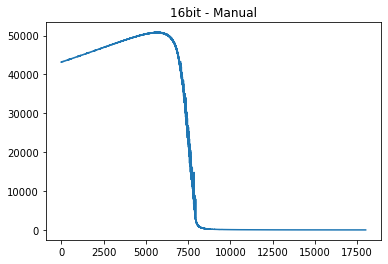

In [21]:
# hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# nx = 1000, n = 1000
# loss_scale = 1.00003466337
# epochs = 5000

plt.plot(np.arange(len(history['step_train_losses'])), np.array(history['step_train_losses']))
plt.title('16bit - Manual')

Text(0.5, 1.0, '16bit - Manual')

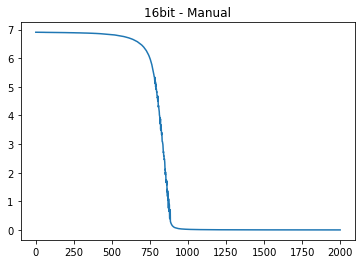

In [22]:
# hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# nx = 1000, n = 1000
# loss_scale = 1.00003466337
# epochs = 5000

plt.plot(np.arange(len(history['epoch_train_losses'])), np.array(history['epoch_train_losses']))
plt.title('16bit - Manual')

Text(0.5, 1.0, '16bit - Manual')

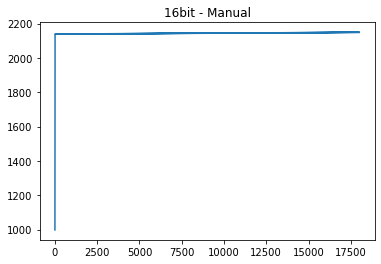

In [23]:
# hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# nx = 1000, n = 1000
# loss_scale = 1.00003466337
# epochs = 5000

plt.plot(np.arange(len(history['max_memory_allocation'])), np.array(history['max_memory_allocation']))
plt.title('16bit - Manual')

## Medium

Text(0.5, 1.0, '16bit - Manual')

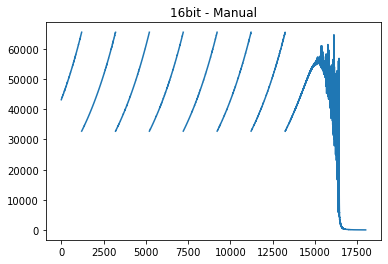

In [21]:
# hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 5000

plt.plot(np.arange(len(history['step_train_losses'])), np.array(history['step_train_losses']))
plt.title('16bit - Manual')

Text(0.5, 1.0, '16bit - Manual')

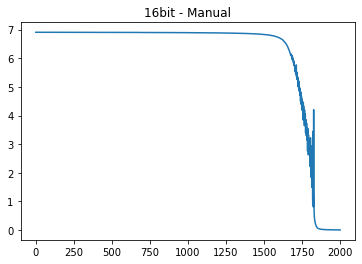

In [22]:
# hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 5000

plt.plot(np.arange(len(history['epoch_train_losses'])), np.array(history['epoch_train_losses']))
plt.title('16bit - Manual')

Text(0.5, 1.0, '16bit - Manual')

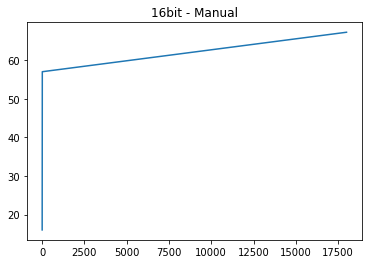

In [23]:
# hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 5000

plt.plot(np.arange(len(history['max_memory_allocation'])), np.array(history['max_memory_allocation']))
plt.title('16bit - Manual')

## Small

Text(0.5, 1.0, '16bit - Manual')

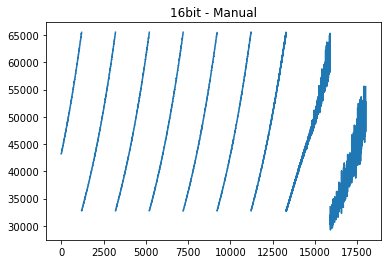

In [23]:
# hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 5000

plt.plot(np.arange(len(history['step_train_losses'])), np.array(history['step_train_losses']))
plt.title('16bit - Manual')

Text(0.5, 1.0, '16bit - Manual')

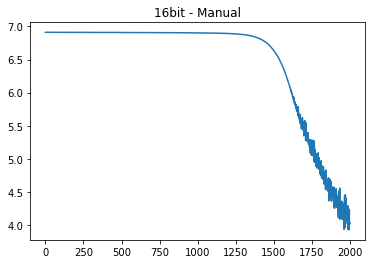

In [24]:
# hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 5000

plt.plot(np.arange(len(history['epoch_train_losses'])), np.array(history['epoch_train_losses']))
plt.title('16bit - Manual')

Text(0.5, 1.0, '16bit - Manual')

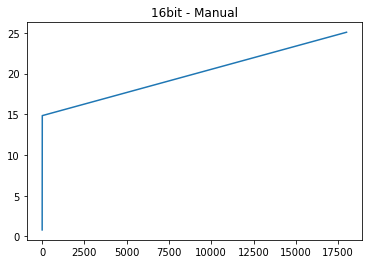

In [25]:
# hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 5000

plt.plot(np.arange(len(history['max_memory_allocation'])), np.array(history['max_memory_allocation']))
plt.title('16bit - Manual')

# Loss Scale

## Large 1.00003466337

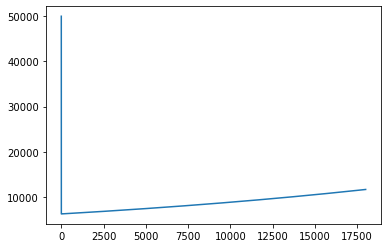

In [24]:
# hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# nx = 1000, n = 1000
# loss_scale = 1.00003466337
# epochs = 2000
plt.plot(np.arange(len(history['loss_scales'])), np.array(history['loss_scales']))

## Medium 1.0003466337

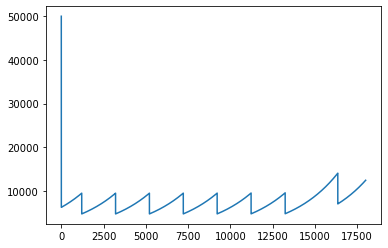

In [24]:
# hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000
plt.plot(np.arange(len(history['loss_scales'])), np.array(history['loss_scales']))

## Small 1.0003466337

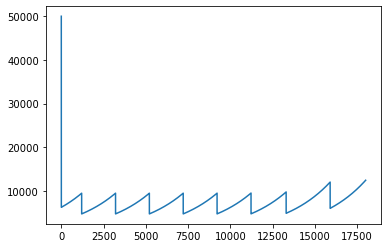

In [26]:
# hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000
plt.plot(np.arange(len(history['loss_scales'])), np.array(history['loss_scales']))

# Running Time

## Large

In [25]:
# hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# nx = 1000, n = 1000
# loss_scale = 1.00003466337
# epochs = 2000
history['timing']

defaultdict(int,
            {'epoch_setup': 0.5326659679412842,
             'get_memory': 8.818579196929932,
             'data': 4.121359825134277,
             'forward': 81.72910189628601,
             'loss': 2.451974630355835,
             'append_losses': 0.8182792663574219,
             'scale_up_loss': 5.267277479171753,
             'backward': 175.84172773361206,
             'check_overflow': 47.842374086380005,
             'to_master_grads': 25.317411422729492,
             'scale_down_master': 29.589402437210083,
             'opt_step': 42.391687631607056,
             'zero_grad': 20.535584449768066,
             'to_model_params': 23.656227827072144,
             'batch_time': 471.1449737548828,
             'append': 0.14146733283996582,
             'epoch_end_time': 1003.9408717155457,
             'loop_end_time': 1006.330281496048,
             'itemize_losses': 0.7787468433380127})

## Medium

In [25]:
# hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000
history['timing']

defaultdict(int,
            {'epoch_setup': 0.5050573348999023,
             'get_memory': 8.785420179367065,
             'data': 4.068981647491455,
             'forward': 18.392555952072144,
             'loss': 2.200606346130371,
             'append_losses': 0.7906265258789062,
             'scale_up_loss': 5.2957353591918945,
             'backward': 30.24211812019348,
             'check_overflow': 24.051188707351685,
             'to_master_grads': 7.910148859024048,
             'scale_down_master': 5.73040771484375,
             'opt_step': 4.771140813827515,
             'zero_grad': 10.36226201057434,
             'to_model_params': 3.3012702465057373,
             'batch_time': 128.2725625038147,
             'append': 0.12371087074279785,
             'epoch_end_time': 651.0775470733643,
             'loop_end_time': 653.4047095775604,
             'itemize_losses': 0.7993831634521484})

## Small

In [27]:
# hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000
history['timing']

defaultdict(int,
            {'epoch_setup': 0.5089833736419678,
             'get_memory': 10.273577690124512,
             'data': 4.125741958618164,
             'forward': 17.64131236076355,
             'loss': 2.2455127239227295,
             'append_losses': 0.7886712551116943,
             'scale_up_loss': 5.360870361328125,
             'backward': 22.721169471740723,
             'check_overflow': 23.214025735855103,
             'to_master_grads': 8.115296840667725,
             'scale_down_master': 5.667067527770996,
             'opt_step': 4.8413801193237305,
             'zero_grad': 10.262449264526367,
             'to_model_params': 3.4654061794281006,
             'batch_time': 121.063241481781,
             'append': 0.1263420581817627,
             'epoch_end_time': 666.531893491745,
             'loop_end_time': 668.9052488803864,
             'itemize_losses': 0.6446473598480225})

# Profiler Results

In [ ]:
# ran for 5 epochs
rankByCriteria(prof, model, criteria='cuda_memory_usage', per_thread=False, per_inp_shapes=False, include_external=False)

In [ ]:
# ran for 5 epochs
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [ ]:
# ran for 5 epochs
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [ ]:
# ran for 5 epochs
rankByCriteria(prof, model, criteria='cpu_time', per_thread=False, per_inp_shapes=False, include_external=False)

# Nvidia Results

## Large

In [26]:
# hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# nx = 1000, n = 1000
# loss_scale = 1.00003466337
# epochs = 2000

!nvidia-smi

Wed Nov 25 21:24:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 0000BCA9:00:00.0 Off |                  Off |
| N/A   32C    P0    37W / 250W |   3175MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
# hidden_layer_dims = [5000, 5000, 5000, 5000, 5000, 5000, 5000]
# nx = 1000, n = 1000
# loss_scale = 1.00003466337
# epochs = 2000

print(torch.cuda.memory_summary(cuda0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  629656 KB |    2050 MB |   18644 GB |   18643 GB |
|       from large pool |  629512 KB |    2040 MB |   18640 GB |   18639 GB |
|       from small pool |     144 KB |      10 MB |       3 GB |       3 GB |
|---------------------------------------------------------------------------|
| Active memory         |  629656 KB |    2050 MB |   18644 GB |   18643 GB |
|       from large pool |  629512 KB |    2040 MB |   18640 GB |

## Medium

In [ ]:
# hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000

!nvidia-smi

In [ ]:
# hidden_layer_dims = [500, 500, 500, 500, 500, 500, 500]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000

print(torch.cuda.memory_summary(cuda0))

## Small

In [28]:
# hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000

!nvidia-smi

Wed Nov 25 23:03:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 0000BCA9:00:00.0 Off |                  Off |
| N/A   32C    P0    38W / 250W |   1153MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
# hidden_layer_dims = [50, 50, 50, 50, 50, 50, 50]
# nx = 1000, n = 1000
# loss_scale = 1.0003466337
# epochs = 2000

print(torch.cuda.memory_summary(cuda0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  474112 B  |   24481 KB |  264875 MB |  264875 MB |
|       from large pool |       0 B  |   11721 KB |  206033 MB |  206033 MB |
|       from small pool |  474112 B  |   12958 KB |   58842 MB |   58842 MB |
|---------------------------------------------------------------------------|
| Active memory         |  474112 B  |   24481 KB |  264875 MB |  264875 MB |
|       from large pool |       0 B  |   11721 KB |  206033 MB |